# Things from 2024-03-13 meeting

#### start this notebook on the orion partition, 1 node, 40 tasks, use --exclusive for additional slurm parameters, and don't forget to type your dataprep conda env path


# ipynb Internal Links / Named Anchors

links to a heading are called internal links or named anchors [see the rules here](https://jupyterlab.readthedocs.io/en/stable/user/urls.html#linking-notebook-sections)

### Table of Contents Example
1) [jump to Section TITLE](#Section-TITLE)
2) [heading with an apostrophe](#Kerrie's-section)
3) [heading with a question mark](#Section-title-is-a-question?)

### Section TITLE

jupyter markdown works a little different than standard markdown, notice capitalization matters in the internal link, it must match exactly


[back to TOC](#Table-of-Contents-Example)


### Kerrie's section

special characters also work differently that standard markdown

[back to top of notebook](#Things-from-2024-03-13-meeting)

### Section title is a question?

to see what to paste in the link part () of an internal link: hover over the paragraph icon of a rendered heading

# Importing your own custom functions

1) Save your functions in a .py script. 

    Here, I've made file called custom_functions.py in the same directory as this notebook. 
    
    It contains a function called my_addition_func that adds two numbers together

2) use 'import' to import your script

3) you can access your functions with '.'

#### Here are a few different ways to do the same thing:

In [ ]:
# plain import

import custom_functions

custom_functions.my_addition_func(1,2)

In [ ]:
# rename your collection of functions on import

import custom_functions as kerrie

kerrie.my_addition_func(1,2)

In [ ]:
# import only a single function

from custom_functions import my_addition_func

my_addition_func(1,2)

In [ ]:
# import a single function and rename it on import

from custom_functions import my_addition_func as add_stuff

add_stuff(1,2)

#### if custom_functions.py was not in the same directory as this notebook

You could create a python package or you could simply tell python where to find your functions. We'll cover the second option here.

Tell python where to find your functions: The operating system has speficic places it looks for executables (like your custom functions or functions from python packages or even linux commands like ls or cd). The list of places the operating system looks is in a system variable called 'PATH'. You need to add the directory where your functions live, e.g. "append your PATH". 

I've made an identical script of custom functions at /our/shared/datasets/temporary/pyscript_custom_functions.py

The process to import functions from this script would be:

In [ ]:
import sys

In [ ]:
basedir='/our/shared/datasets/dir/'

In [ ]:
# don't append the script, append the directory where the script lives
sys.path.append(basedir+'temporary/')

In [ ]:
import pyscript_custom_functions as kerrie

In [ ]:
kerrie.my_addition_func(1,2)


# Reproject bounding box

In [ ]:
# packages
import xarray as xr
import rioxarray as rio

In [5]:
# paths
path_to_raw_data = 'raw_data/'
path_to_climatic = basedir + path_to_raw_data + 'ERA5/month/'

path_to_pre = path_to_climatic + 'era5_monthly_means_50_21_pre.nc'
path_to_atlas_ai=basedir + path_to_raw_data + 'ATLAS-AI project/ATLAS-AI/AWI/2022_AWI_43-SSA-contiguous_AWI_43-SSA_2003.tif'

# btw, I highly recommend replacing the space with an underscore in the dir "ATLAS-AS project"
# spaces in dir and file names can cause problems in a linux operating system

In [ ]:
# precipitation
pre_world = xr.open_dataarray(path_to_pre, decode_coords = "all")
pre_world.rio.write_crs(4326, inplace = True)

# AWI
atlas_ai=xr.open_dataset(path_to_atlas_ai)
atlas_ai_unproj=atlas_ai.rio.reproject(4326) # reproject the whole thing
minx,miny,maxx,maxy = atlas_ai_unproj.rio.bounds() # now get the bounds
print(minx,miny,maxx,maxy)

# clip precip
pre = pre_world.rio.clip_box(minx,miny,maxx,maxy)

# plot
pre.isel(time=0).plot()

# Using command-line tools from inside an ipynb

demonstrating here with the climate-indices package, which means I've installed all other packages I need with conda (including nco as in the [instructions](https://climate-indices.readthedocs.io/en/latest/)) and then installed climate-indices with pip at the end

```
conda activate /work/hpc/users/username/envs/dataprep
conda install -c conda-forge nco
python -m pip install climate-indices
```

One thing to note is that the climate-indices package is not very flexible with data inputs. It requires very specific dimension names, dimension order, and variable units. For example it expects:
1) dimension names 'time', 'lat', 'lon'
2) dimension order ('lat','lon','time')
3) precip units mm, millimeters, millimeter, mm/dy, inches, or inch 
4) I'm sure there's a ton more things, but these are the only things I ran into so far

So, ERA5 'latitude' and 'longitude' coordinate names will raise an error. They must be 'lat' and 'lon'. The order of dimensions ('time','lat','lon') will raise an error. The units (m) of ERA5 precipitation will raise an error. I found this out by trial and error and found the fixes by digging through the [source code for the spi function](https://github.com/monocongo/climate_indices/blob/master/src/climate_indices/__spi__.py).

For ERA5, this means before you can use climate-indices functions you have to either:
1) go into the source code of climate-indices and add support all these things
2) re-write the netcdf files to change the coordinate names 

The first option may be fastest but is less reproducible. The second option will allow your code to be more reproducible. There are a few options for re-writing netcdf files. You can use a command line tool like nco or cdo but unless you use a special configuration or install additional software to allow parallelization, large files (here ~11G) will take a long time to rewrite. I tried using nco for this but gave up after a single file wasn't finished writing after 20 minutes. A quicker method to re-write netcdf files is using dask and xarray, which I will show below. Using 1 node of cores, you can re-write a file in 2-3 minutes.

Then, after you've re-written your netcdf files to have all the correct metadata labels you can call climate-indices functions on your new files.

Example usage of climate-indices: calculate SPI on ERA5 monthly precip, at the command line you would use  
```
process_climate_indices --index spi --periodicity monthly --netcdf_precip prfile --var_name_precip tp --output_file_base outdir --scales 6 12 --calibration_start_year 1951 --calibration_end_year 2021 --multiprocessing all
```

You have to translate that with python subprocess to issue the command inside a ipynb or py script. But, you also need to activate the conda environment where you've installed climate-indices every single time you want to use commands from that package. This is very clunky. I've never used a command line tool from python like this and am not sure what kind of problems you may run into. 

It seems the better way to use the climate-indices package would be from a bash script. I provide an example of that at /our/shared/datasets/dir/temporary/compute_spi.sh. Theoretically you could call that script from python too, but I couldn't get that working 

Below is how you could accomplish using climate-indices tools from python with subprocess.

### rewrite netcdf files to change dimension/coordinate names

In [2]:
import xarray as xr
import dask
from dask.distributed import Client,LocalCluster

In [36]:
# start a LocalCluster
# we are using dask.distributed LocalCluster because I couldn't get this to work with regular dask (single-machine scheduler)

nworkers=40  # make this the same as how many tasks you launched your jupyter session with
cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1) # a cluster where each thread is a separate process or "worker"
client=Client(cluster)  # connect to your compute cluster
client.wait_for_workers(n_workers=nworkers,timeout=10) # wait up to 10s for the cluster to be fully ready, error if not ready in 10s
client # print info

In [ ]:
# something weird is going on with the ERA5 file when time gets decoded
# so first, don't decode time
# ds=xr.open_dataset(path_to_pre,chunks='auto',decode_times=False,lock=False).rename({'latitude':'lat','longitude':'lon'})
ds=xr.open_dataset(path_to_pre,chunks='auto',decode_times=False).rename({'latitude':'lat','longitude':'lon'})

# then, copy the attributes from the un-decoded time variable
# we'll use these later when we re-write the netcdf
calendar=ds.time.attrs['calendar']
units=ds.time.attrs['units']

# then, decode time with the cftime library
ds=xr.decode_cf(ds,use_cftime=True)
ds=ds.transpose('lat','lon','time')

# change precip units
ds['tp']=ds.tp*1000. # m-->mm
ds.tp.attrs['units']='mm'
ds

In [6]:
# new file path and name
outdir=basedir+'temporary/'
prfile=outdir+'era5_monthly_means_50_21_pre.nc'

In [ ]:
%%time

# the encodings below allow you to keep the same dimension/coordinate attributes from the original file
# we are essentially overriding some xarray default settings here
time_encoding={'_FillValue':None,'calendar':calendar,'units':units} 
lat_encoding={'_FillValue':None}
lon_encoding={'_FillValue':None}

# compute and write new file in parallel
output=ds.to_netcdf(prfile,
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding},
            compute=False)
output.compute()

### now run climate-indices command line tool

In [ ]:
import subprocess
import matplotlib.pyplot as plt

In [ ]:
# below works for me but probably won't for others
# this is because I'm using my own installation of miniconda instead of using the Orion system module conda
# we'll probably have to go through it together and modify a few things to get it working 

# user conda information
user_home='$HOME/'
conda_init_file=user_home+'miniconda3/etc/profile.d/conda.sh'  # you need to find your conda.sh script
conda_env='/workspace/username/envs/dataprep' # path user-specific conda env

# create command enclosed in ""
# everything but the final command should end with ;
command_conda_init=". "+conda_init_file+";"               # initialize conda
command_env_activate="conda activate "+conda_env+";"      # activate conda environment 
command_echo_env="echo 'conda env =' $CONDA_DEFAULT_ENV;" # print active env name
command_spi="process_climate_indices "+\
                "--index spi "+\
                "--periodicity monthly "+\
                "--netcdf_precip "+prfile+" "\
                "--var_name_precip tp "+\
                "--output_file_base "+outdir+" "\
                "--scales 6 12 "+\
                "--calibration_start_year 1951 "+\
                "--calibration_end_year 2021 "+\
                "--multiprocessing all"

In [ ]:
# double check spaces are all good in command_spi
command_spi

In [ ]:
# string all the commands together
# climate-indices commands take a very long time, this took 30 minutes to run
# also you get a lot of divide by zero and nan runtime warning and unless 
# the climate-indices source is modified, I don't think there is any way to silence 
# these when calling from python like this

subprocess.run(command_conda_init+
               command_env_activate+
               command_echo_env+
               command_spi,
               shell=True)

In [35]:
# take a look at the results
ds_g06=xr.open_dataset(basedir+'temporary/_spi_gamma_06.nc')
ds_g12=xr.open_dataset(basedir+'temporary/_spi_gamma_12.nc')
ds_p06=xr.open_dataset(basedir+'temporary/_spi_pearson_06.nc')
ds_p12=xr.open_dataset(basedir+'temporary/_spi_pearson_12.nc')
ds_g06

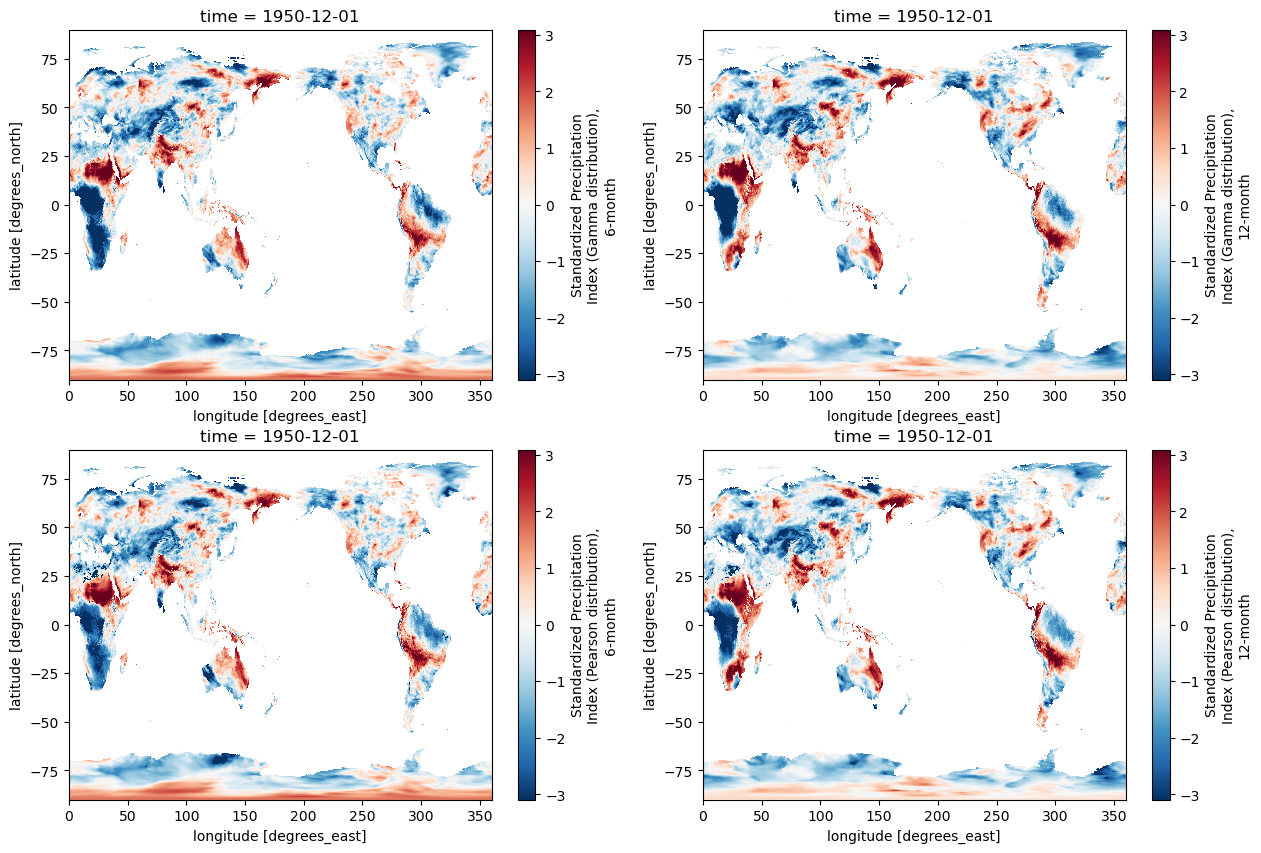

In [24]:
# 6-month spi so first 5 time indexes will be nan
# import cartopy
fig=plt.figure(figsize=(15,10))

ax=fig.add_subplot(221)
ds_g06.spi_gamma_06.isel(time=11).plot(ax=ax)

ax=fig.add_subplot(222)
ds_g12.spi_gamma_12.isel(time=11).plot(ax=ax)


ax=fig.add_subplot(223)
ds_p06.spi_pearson_06.isel(time=11).plot(ax=ax)

ax=fig.add_subplot(224)
ds_p12.spi_pearson_12.isel(time=11).plot(ax=ax)

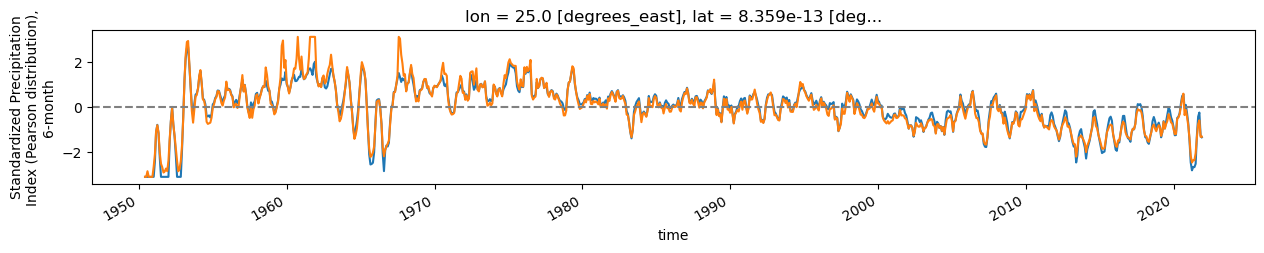

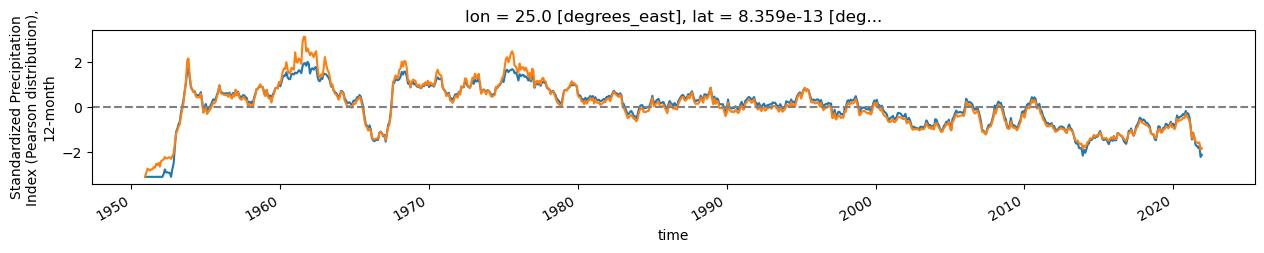

In [23]:
fig=plt.figure(figsize=(15,2))
y1=ds_g06.spi_gamma_06.sel(lat=0,lon=25,method='nearest')  # gamma in blue
y2=ds_p06.spi_pearson_06.sel(lat=0,lon=25,method='nearest') # pearson in orange
y1.plot()
y2.plot()
plt.axhline(y=0,color='grey',linestyle='--')
plt.show()


fig=plt.figure(figsize=(15,2))
y1=ds_g12.spi_gamma_12.sel(lat=0,lon=25,method='nearest')  # gamma in blue
y2=ds_p12.spi_pearson_12.sel(lat=0,lon=25,method='nearest') # pearson in orange
y1.plot()
y2.plot()
plt.axhline(y=0,color='grey',linestyle='--')
plt.show()